In [290]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
from IPython.display import display
import math

In [6]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [7]:
os.chdir(os.environ.get('USER_PATH'))

In [200]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy
from src.utils.modelUtil import Params, load_model, convert_coordinates
from src.utils.labelUtil import getSuperpopBins, repeat_pop_arr
from src.utils.decorators import timer
from src.models.modelSelection import modelSelect
from src.models.modelParamsSelection import Selections
from src.models import Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, GcdLoss
from src.main.settings_model import parse_args
from src.models.Ge3Net import Ge3NetBase
import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and use valid data 

In [9]:

# Specify the dataset to be evaluated
# chm22 pca full dataset and model


In [312]:
data_id=['data_id_1_geo', 'data_id_2_geo', 'data_id_3_geo']
model_id_data_id=['Model_B_exp_id_24_data_id_1_geo', 'Model_B_exp_id_9_data_id_2_geo', 'Model_B_exp_id_1_data_id_3_geo']
def loadModelStats(data_id, model_id_data_id):
    results, modelStats = {}, {}
    
    for d, m in zip(data_id, model_id_data_id):
        results_gen, modelStats_gen = {}, {}
        labels_path = osp.join(os.environ['OUT_PATH'], 'humans/labels', d)
        data_path = osp.join(os.environ['OUT_PATH'],'humans/labels', d)
        models_path = osp.join(os.environ['OUT_PATH'],'humans/training', m)
        dataset_type='test'
        config={}
        config['data.labels']=labels_path 
        config['data.dir']=data_path 
        config['models.dir']=models_path
        config['data.dataset_type']=dataset_type
        config['cuda']='cuda'
        config['model.loadBest']=True
        json_path = osp.join(config['models.dir'], 'params.json')
        assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
        params = Params(json_path)
        params.rtnOuts=True
        params.mc_dropout=False
        params.mc_samples=100
        params.cp_tol=1
        params.evalCp=True
        params.evalBalancedGcd=True
        params.evalExtraMainLosses=True
        for gen in [[2],[4],[8]]:
            
            params.test_gens=gen
            results_gen[str(gen)], _, _, modelStats_gen[str(gen)]=test.main(config, params)
            print(f"num_samples={results_gen[str(gen)].t_out.coord_main.shape[1]}")
        results[m]=results_gen
        modelStats[m]=modelStats_gen
    return results, modelStats

In [313]:
results, modelStats = loadModelStats(data_id, model_id_data_id)

 device used: cuda
Loading the datasets...
Finished '_geoConvertLatLong2nVec' in 0.0151 secs
Finished 'mapping_func' in 0.0818 secs
Finished 'pop_mapping' in 0.0350 secs
Finished 'pop_mapping' in 0.0341 secs
Finished 'transform_data' in 8.4852 secs
Finished '__init__' in 8.8382 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model BiRNN:60355
Parameter count for model logits_Block:2289
Total parameters:31810147
best val loss metrics : {'l1_loss': 0.24658535200982565, 'mse': 0.05564984682895078, 'smooth_l1': 0.027765671336183614, 'weighted_loss': 0.24658535200982565, 'loss_main': 1058.682288578713, 'loss_aux': 2325.0821036255998}
at epoch : 109
train loss metrics: {'l1_loss': 0.12335511097228757, 'mse': 0.02516377482076734, 'smooth_l1': 0.012570951358345368, 'weighted_loss': 0.12335511097228757, 'loss_main': 563.9394605949345, 'loss_aux': 2042.904725664368}
best val cp metrics : {'loss_cp': 0.0970872686735664, 'prMetrics': OrderedDict([('Precision', array(0.)), ('

Parameter count for model AuxNetwork:31747503
Parameter count for model BiRNN:60355
Parameter count for model logits_Block:2289
Total parameters:31810147
best val loss metrics : {'l1_loss': 0.2512681875850763, 'mse': 0.05761978947927245, 'smooth_l1': 0.02873942095975487, 'weighted_loss': 0.2512681875850763, 'loss_main': 1083.5239082148566, 'loss_aux': 2351.7726908949485}
at epoch : 117
train loss metrics: {'l1_loss': 0.13661600979769467, 'mse': 0.02806319853721209, 'smooth_l1': 0.01402136457190717, 'weighted_loss': 0.13661600979769467, 'loss_main': 618.9979442740316, 'loss_aux': 2130.159258549206}
best val cp metrics : {'loss_cp': 0.10304137584873709, 'prMetrics': OrderedDict([('Precision', array(0.)), ('Recall', array(0.)), ('Accuracy', array(0.98634977)), ('A_major', array(1.)), ('BalancedAccuracy', 0.5)])}
train cp metrics: {'loss_cp': 0.19162867486357896, 'prMetrics': OrderedDict([('Precision', array(0.03179653)), ('Recall', array(0.39598124)), ('Accuracy', array(0.90329555)), ('A_

Finished 'load_model' in 0.2478 secs
is the model on cuda? : True
Finished 'batchLoopValid' in 0.4701 secs
Finished 'main' in 9.8612 secs
num_samples=800


In [307]:
def get_all_accr(results, modelStats):    
    ls1=list(results.t_accr.keys())
    ls2=list(results.t_balanced_gcd.keys())
    df_test_accr = pd.DataFrame()
    
    df_accr_sub = pd.DataFrame([list(results.t_accr.values())])
    df_test_accr=pd.concat([df_test_accr, df_accr_sub], axis=0, ignore_index=True)
    df_test_accr.columns=ls1
    df_test_balanced_accr = pd.DataFrame()
    
    df_balanced_accr_sub = pd.DataFrame([list(results.t_balanced_gcd.values())])
    df_test_balanced_accr=pd.concat([df_test_balanced_accr,df_balanced_accr_sub], axis=0, ignore_index=True)
    df_test_balanced_accr.columns=ls2
    df_test_accr=pd.concat([df_test_accr, df_test_balanced_accr], axis=1)
    df_test_accr['dataset']='test'
#     df_all_accr=pd.concat([df_valid_accr, df_test_accr], axis=0, ignore_index=True)
    return df_test_accr

In [314]:
for d, m in zip(data_id, model_id_data_id):
    print(results[m]['[2]'].t_accr)

{'loss_main': 954.8153470031546, 'loss_aux': 2235.5040615141957, 'l1_loss': 0.22259232770757345, 'mse': 0.04722227908835426, 'smooth_l1': 0.02358170446161216, 'weighted_loss': 0.22259232770757345}
{'loss_main': 964.4954022082019, 'loss_aux': 2251.8603943217668, 'l1_loss': 0.22540719883675078, 'mse': 0.045575433965737135, 'smooth_l1': 0.022753864733578655, 'weighted_loss': 0.22540719883675078}
{'loss_main': 947.4856427444795, 'loss_aux': 2184.693832807571, 'l1_loss': 0.21981929165331723, 'mse': 0.04812666462798976, 'smooth_l1': 0.024015442520286007, 'weighted_loss': 0.21981929165331723}


In [311]:
results['Model_B_exp_id_1_data_id_3_geo'].keys()

dict_keys(['[8]'])

In [316]:
df_ls=[]
i=0
m='Model_B_exp_id_1_data_id_3_geo'
for d, m in zip(data_id, model_id_data_id):
    for gen in [[2],[4],[8]]:
        df=pd.DataFrame()
        results_gen1=results[m][str(gen)]
        modelStats_gen1=modelStats[m][str(gen)]
        df=get_all_accr(results_gen1, modelStats_gen1)
        df_copy=df.copy(deep=True)
        df_ls.append(df_copy)
        print(f"Test for gen:{gen[0]}, model_id_data_id: {m}")
        display(df_ls[i])
        i+=1

Test for gen:2, model_id_data_id: Model_B_exp_id_24_data_id_1_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,954.815347,2235.504062,0.222592,0.047222,0.023582,0.222592,1023.391479,1087.747803,997.480774,943.091125,639.271301,test


Test for gen:4, model_id_data_id: Model_B_exp_id_24_data_id_1_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,1014.18433,2169.229795,0.237311,0.051103,0.025493,0.237311,1197.941406,1188.876709,1083.078125,1021.392944,709.323914,test


Test for gen:8, model_id_data_id: Model_B_exp_id_24_data_id_1_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,1184.280568,2224.032666,0.275722,0.068866,0.034328,0.275722,1405.444702,1355.615479,1235.481934,1251.009155,852.901855,test


Test for gen:2, model_id_data_id: Model_B_exp_id_9_data_id_2_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,964.495402,2251.860394,0.225407,0.045575,0.022754,0.225407,1082.561768,1120.657227,980.163818,947.136658,671.311584,test


Test for gen:4, model_id_data_id: Model_B_exp_id_9_data_id_2_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,1082.9358,2233.638218,0.251951,0.056852,0.028319,0.251951,1313.875854,1305.255005,1117.162109,1111.383057,775.55249,test


Test for gen:8, model_id_data_id: Model_B_exp_id_9_data_id_2_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,1243.780844,2252.019511,0.289172,0.072702,0.036182,0.289172,1478.049683,1466.763428,1285.371704,1262.885376,938.403809,test


Test for gen:2, model_id_data_id: Model_B_exp_id_1_data_id_3_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,947.485643,2184.693833,0.219819,0.048127,0.024015,0.219819,992.589539,1076.8927,998.040894,1000.553589,646.347778,test


Test for gen:4, model_id_data_id: Model_B_exp_id_1_data_id_3_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,1038.55252,2173.637965,0.241181,0.055097,0.027452,0.241181,1100.404053,1145.696655,1156.335449,1015.795776,716.350464,test


Test for gen:8, model_id_data_id: Model_B_exp_id_1_data_id_3_geo


,loss_main,loss_aux,l1_loss,mse,smooth_l1,weighted_loss,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,1181.397855,2182.562839,0.275145,0.070874,0.035352,0.275145,1258.84729,1335.23877,1286.852783,1222.276489,836.635986,test


In [181]:
ls1=list(modelStats['Model_B_exp_id_24_data_id_1_geo']['t_accr'].keys())
ls2=list(modelStats['Model_B_exp_id_24_data_id_1_geo']['t_balanced_gcd'].keys())

In [182]:

df_accr = pd.DataFrame()
for m in model_id_data_id:
    df_accr_sub = pd.DataFrame([list(modelStats[m]['t_accr'].values())])
    df_accr=pd.concat([df_accr,df_accr_sub], axis=0, ignore_index=True)
df_accr.columns=ls1
df_balanced_accr = pd.DataFrame()
for m in model_id_data_id:
    df_balanced_accr_sub = pd.DataFrame([list(modelStats[m]['t_balanced_gcd'].values())])
    df_balanced_accr=pd.concat([df_balanced_accr,df_balanced_accr_sub], axis=0, ignore_index=True)
df_balanced_accr.columns=ls2
df_valid_accr=pd.concat([df_accr, df_balanced_accr], axis=1)
df_valid_accr['dataset']='valid'

In [183]:
ls1=list(results['Model_B_exp_id_24_data_id_1_geo'].t_accr.keys())
ls2=list(results['Model_B_exp_id_24_data_id_1_geo'].t_balanced_gcd.keys())
df_test_accr = pd.DataFrame()
for m in model_id_data_id:
    df_accr_sub = pd.DataFrame([list(results[m].t_accr.values())])
    df_test_accr=pd.concat([df_test_accr, df_accr_sub], axis=0, ignore_index=True)
df_test_accr.columns=ls1
df_test_balanced_accr = pd.DataFrame()
for m in model_id_data_id:
    df_balanced_accr_sub = pd.DataFrame([list(results[m].t_balanced_gcd.values())])
    df_test_balanced_accr=pd.concat([df_test_balanced_accr,df_balanced_accr_sub], axis=0, ignore_index=True)
df_test_balanced_accr.columns=ls2
df_test_accr=pd.concat([df_test_accr, df_test_balanced_accr], axis=1)
df_test_accr['dataset']='test'

In [184]:
df_all_accr=pd.concat([df_valid_accr, df_test_accr], axis=0, ignore_index=True)

# accr metrics

In [185]:
df_all_accr

,l1_loss,mse,smooth_l1,weighted_loss,loss_main,loss_aux,meanBalancedGcdSp,meanBalancedGcdGp,medianBalancedGcdSp,medianBalancedGcdGp,median,dataset
0,0.246585,0.055650,0.027766,0.246585,1058.682289,2325.082104,1185.722046,1418.281860,1152.150269,1239.806763,730.513611,valid
1,0.251268,0.057620,0.028739,0.251268,1083.523908,2351.772691,1218.954712,1450.525024,1174.178955,1276.765747,776.465149,valid
2,0.245365,0.058508,0.029181,0.245365,1056.111786,2300.368586,1236.363525,1433.415894,1096.512329,1157.433472,704.863342,valid
3,0.236757,0.052492,0.026192,0.236757,1013.998118,2207.738983,1156.676758,1156.896118,1073.757324,1049.677124,691.597290,test
4,0.245025,0.054131,0.026977,0.245025,1051.094488,2242.640102,1211.867188,1234.473389,1116.048706,1029.236328,742.732361,test
5,0.235093,0.054272,0.027069,0.235093,1011.922681,2182.042938,1071.295288,1135.324341,1098.259644,1049.444092,687.709778,test


In [242]:
# mean gcd after masking with true cp


ls=[]
for d, m in zip(data_id, model_id_data_id):
    loss_main={}
    labels_path = osp.join(os.environ['OUT_PATH'], 'humans/labels', d)
    data_path = osp.join(os.environ['OUT_PATH'],'humans/labels', d)
    models_path = osp.join(os.environ['OUT_PATH'],'humans/training', m)
    dataset_type='test'
    config={}
    config['data.labels']=labels_path 
    config['data.dir']=data_path 
    config['models.dir']=models_path
    config['data.dataset_type']=dataset_type
    config['cuda']='cuda'
    config['model.loadBest']=True
    json_path = osp.join(config['models.dir'], 'params.json')
    assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
    params = Params(json_path)
    params.rtnOuts=True
    params.mc_dropout=False
    params.mc_samples=100
    params.cp_tol=1
    params.test_gens=[0,2,4,8]
    params.evalCp=True
    params.evalBalancedGcd=True
    params.evalExtraMainLosses=True
    test_results, dataset, _, _=test.main(config, params)
    
    #BOCD
    y_pred = test_results.t_out.coord_main.squeeze(0)
    n_vec_dim=y_pred.shape[-1]
    data_tensor = torch.tensor(y_pred).float()
    batch_size_cpd = data_tensor.shape[0]
    mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
    mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
    cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
    cov_x = cov_prior
    likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
    T = params.n_win
    model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
    posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')
    #
    
    trueCp=dataset.data['cps']
#     predCp=getCpPred(cpMethod.gradient.name, torch.tensor(test_results.t_out.coord_main).squeeze(0).float(), cpThresh=0.1, \
#                      Batch_size=test_results.t_out.coord_main.shape[1], T=test_results.t_out.coord_main.shape[2])
    predCp=getCpPred(cpMethod.BOCD.name, model_cpd.cp, cpThresh=5.0, \
                   Batch_size=test_results.t_out.coord_main.shape[1], T=test_results.t_out.coord_main.shape[2])
    
    print(f"num_samples={test_results.t_out.coord_main.shape[1]}")
    trueCpMask=(trueCp==0)
    predCpMask=(predCp==0)
    predCp=predCp.detach().cpu().numpy()
    predCpMask=predCpMask.detach().cpu().numpy()
    intersectSum=trueCp+predCp
    intersectCp=(intersectSum!=2)
    loss_main['no_mask']= test_results.t_accr['loss_main']
    coord_main=test_results.t_out.coord_main.squeeze(0)
    loss_main['trueCpMask']= GcdLoss()(coord_main*trueCpMask[...,np.newaxis],\
                            dataset.data['y']*trueCpMask[...,np.newaxis])/trueCpMask.sum()
    loss_main['intersectCpMask']=GcdLoss()(coord_main*intersectCp[...,np.newaxis],\
                            dataset.data['y']*intersectCp[...,np.newaxis])/intersectCp.sum()
    loss_main['predCpMask']= GcdLoss()(coord_main*predCpMask[...,np.newaxis],\
                            dataset.data['y']*predCpMask[...,np.newaxis])/predCpMask.sum()
    ls.append(loss_main)

 device used: cuda
Loading the datasets...
Finished '_geoConvertLatLong2nVec' in 0.0576 secs
Finished 'mapping_func' in 0.2924 secs
Finished 'pop_mapping' in 0.1277 secs
Finished 'pop_mapping' in 0.1277 secs
Finished 'transform_data' in 32.0347 secs
Finished '__init__' in 35.4390 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model BiRNN:60355
Parameter count for model logits_Block:2289
Total parameters:31810147
best val loss metrics : {'l1_loss': 0.24658535200982565, 'mse': 0.05564984682895078, 'smooth_l1': 0.027765671336183614, 'weighted_loss': 0.24658535200982565, 'loss_main': 1058.682288578713, 'loss_aux': 2325.0821036255998}
at epoch : 109
train loss metrics: {'l1_loss': 0.12335511097228757, 'mse': 0.02516377482076734, 'smooth_l1': 0.012570951358345368, 'weighted_loss': 0.12335511097228757, 'loss_main': 563.9394605949345, 'loss_aux': 2042.904725664368}
best val cp metrics : {'loss_cp': 0.0970872686735664, 'prMetrics': OrderedDict([('Precision', array(0.)), 

In [243]:
ls #BOCD

[{'intersectCpMask': 1038.727160534413,
  'no_mask': 1013.9981183242016,
  'predCpMask': 1132.586826645234,
  'trueCpMask': 1156.8342641997328},
 {'intersectCpMask': 1073.4568282647817,
  'no_mask': 1051.0944882224976,
  'predCpMask': 1157.2893472921833,
  'trueCpMask': 1193.5793610684702},
 {'intersectCpMask': 1037.370101478777,
  'no_mask': 1011.9226810048659,
  'predCpMask': 1128.2778124729018,
  'trueCpMask': 1154.7523056509863}]

In [236]:
ls #gradient

[{'intersectCpMask': 1071.2902175256045,
  'no_mask': 1013.9981183242016,
  'predCpMask': 1191.6761865692715,
  'trueCpMask': 1156.8342641997328},
 {'intersectCpMask': 1106.3707654069924,
  'no_mask': 1051.0944882224976,
  'predCpMask': 1210.3033669452777,
  'trueCpMask': 1193.5793610684702},
 {'intersectCpMask': 1069.8078593593457,
  'no_mask': 1011.9226810048659,
  'predCpMask': 1180.3186086093122,
  'trueCpMask': 1154.7523056509863}]

In [241]:
# mean gcd after masking with intersection of true and predicted cp
trueCpMask.sum()

923843

In [240]:
predCpMask.sum()

939588

In [239]:
intersectCp.sum()

939588

# training related metrics

<b> Model Parameter Counts </b>
<br />Parameter count for model AuxNetwork:31747503
<br />Parameter count for model BiRNN:60355
<br />Parameter count for model logits_Block:2289
<br />Total parameters:31810147

<b> GPU Specs</b>
<br /> CLASS:SH3_G4FP64
<br /> CPU_FRQ:2.50GHz
<br /> CPU_GEN:RME
<br /> CPU_MNF:AMD
<br /> CPU_SKU:7502P
<br /> GPU_BRD:TESLA
<br /> GPU_CC:7.0
<br /> GPU_GEN:VLT
<br /> GPU_MEM:32GB
<br /> GPU_SKU:V100S_PCIE
<br /> IB:HDR
<br /> 
<br /> CPU_FRQ:2.40GHz
<br /> CPU_GEN:BDW
<br /> CPU_MNF:INTEL
<br /> CPU_SKU:E5-2640v4
<br /> GPU_BRD:TESLA
<br /> GPU_CC:7.0
<br /> GPU_GEN:VLT
<br /> GPU_MEM:16GB
<br /> GPU_SKU:V100_SXM2
<br /> IB:EDR

<b> Data Load Time </b>
<br/>******Train******
<br/>Finished 'transform_data' in 68.4945 secs
<br/>Finished 'dataLoad__init__' in 90.8475 secs
<br/>******Valid******
<br/>Finished 'transform_data' in 38.4268 secs
<br/>Finished 'dataLoad__init__' in 53.2155 secs
<br/>******Test******
<br/>Finished 'transform_data' in 31.0835 secs
<br/>Finished 'dataLoad__init__' in 42.5810 secs

<br/>******Train******
<br/>Finished 'transform_data' in 74.1822 secs
<br/>Finished 'dataLoad__init__' in 101.4063 secs
<br/>******Valid******
<br/>Finished 'transform_data' in 41.3000 secs
<br/>Finished 'dataLoad__init__' in 55.1750 secs
<br/>******Test******
<br/>Finished 'transform_data' in 34.0665 secs
<br/>Finished 'dataLoad__init__' in 44.8732 secs

<b> Training time metrics </b>
<br/> Finished '1_epoch_LoopTrain' in 10.0368 secs
<br/> Finished 'batchLoopValid' in 2.4894 secs
<br/> Finished '1_epoch_LoopValid' in 1.8716 secs
<br/>Finished 'launchTraining' in 2813.0047 secs
<br/> Finished 'main' in 3006.3466 secs
<br/> best epoch:133
<br/> total_epochs:198

<b> Training time metrics </b>
<br/>Finished '1_epoch_LoopValid' in 2.0109 secs
<br/>Finished '1_epoch_LoopTrain' in 13.5793 secs
<br/>Finished '1_epoch_LoopValid' in 2.3216 secs
<br/>Finished 'launchTraining' in 4109.2407 secs
<br/>Finished 'main' in 4318.6068 secs
<br/> best epoch:133
<br/> total_epochs:198

<b> Inference metrics (without mc dropout)</b> 
<br/>Finished 'transform_data' in 31.4642 secs
<br/>Finished 'dataLoad__init__' in 34.9018 secs
<br/>Finished '1_epoch_LoopValid' in 1.6459 secs
<br/>Finished 'main' in 37.0414 secs

<b> Inference metrics (without mc dropout 100 samples)</b> 
<br/>Finished 'transform_data' in 31.4112 secs
<br/>Finished 'dataLoad__init__' in 35.0218 secs
<br/>Finished '1_epoch_LoopValid' in 63.4109 secs
<br/>Finished 'main' in 98.9647 secs

In [159]:
num_test_samples=2964

In [149]:
columns_ls=['training_time', '1_epoch_train', '1_epoch_valid', '1_epoch_test', 'train_data_load', 'train_data_transform', \
            'valid_data_load', 'valid_data_transform', 'test_data_load', 'test_data_transform','best_epoch',\
            'total_epochs', 'inference_time', 'num_samples', 'inf_data_load', 'inf_valid_loop']

In [ ]:
values=['','4109.2407', '14.7462', '2.5695', '2.0109', '', '']

In [12]:
results_coord_main=results.t_out.coord_main.mean(0)

In [13]:
y_pred = results_coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 154.1588 secs


In [14]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}

In [15]:
cp_target.shape

(2964, 317)

In [36]:
# index = 2500
# index=2620
# index=2650
# index=3000
# index=3100
# index=2300
# index=2320
# index=2338 #interesting Mansi pop
# index=2339 # nice example showing Karitiana
# index=2344 #interesting clusters of Mongolia
# index=2346 # interesting African diversity
# index=2355#int. Iranian sample
# index=2366# Piapioco and Pima both
# index=2388#int example
# index=2398#Biaka/Luhya
# index=2403#Quechua
# index=2414#incorrect Khomani San
# index=2421#uyugur
# index=2465#balochi similar to MAkrani slave trade
# index=2482# interesting Indo euro
# index=2876 #icelandic example
# index=3533 #San and icelandic
# index=1007 #Surui
# index=2974 #Surui nice example
#1873# nice diversity of samples
index=np.random.choice(idxOfInterest)
# index=830
# index=511
# index=1040 #San
index=1007 #2205, for 3_geo
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results_coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]

1007


In [37]:
y_predSample.shape

(317, 3)

In [38]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [39]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [40]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [41]:
mappedSpArr=getSuperpopBins(labels_path, y_predSample.reshape(-1,3))
# mappedSpArr=mappedSpArr.squeeze(1)

Finished 'getSuperpopBins' in 0.0517 secs


In [42]:
y_predsTrue=test_dataset.data['y'].reshape(-1,3)
superpopsTrue=test_dataset.data['superpop'].reshape(-1,)

In [43]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_preds=kwargs.get('y_preds')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    fig, ax = plt.subplots(figsize=(12,14))
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,1,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis is not None:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_preds, superpops, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colors_Sp = sns.color_palette("bright", 10)
        del colors_Sp[1]
        del colors_Sp[4]
        del colors_Sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colors_Sp)}
        colorsPop_sp_dict[-1]=(0.7,0.7,0.7) # grey color
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right",fontsize=15)
    ax1.add_artist(lgnd)    
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopSample)))
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopSample), colors_pop)}

    alpha=[1]*len(y_predSample)
    if cpShow is None:
#         alpha=(pred_cps==0).astype(float)
        unknownIdx=np.nonzero(pred_cps)[0]
        print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(y_predSample)}")
        granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
        colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
        mappedSpArr[unknownIdx]=-1
    
    ax1.scatter(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(granularPopNames, alpha)], s=50, zorder=0) 
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2], \
               color = [colors_pop_dict[x] for x in granularPopSample], marker='X', s=200, zorder=0)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = val))
    patches.append(mpatches.Patch(color = (0.9,0.9,0.9), label = "UNK"))
    ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    #chm plot ground truth
    ax2.scatter(np.arange(len(y_trueSample)),np.ones(len(y_trueSample)),\
                color=[colors_pop_dict[x] for x in granularPopSample], marker='s')
    ax2.set_title('Labeled Chromosome22', fontsize=30, y=0.3)
    #chm plot of predictions
    ax3.scatter(np.arange(len(mappedSpArr)),np.ones(len(mappedSpArr)),\
                color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr,alpha)], marker='s')
    ax3.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, 316)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    fig.tight_layout()
    plt.show()
    plt.close('all')

number of changepoints removed:26,0.08201892744479496


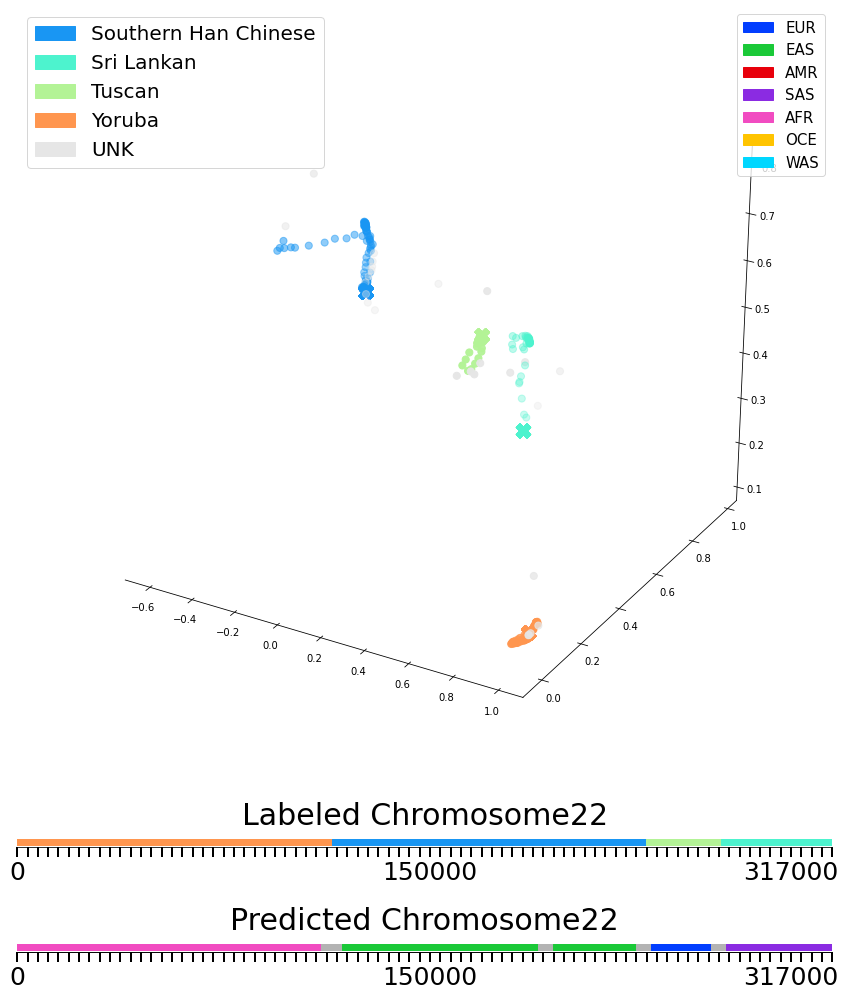

Finished 'plot_sample' in 0.8543 secs


In [44]:
plot_sample(namesSample, y_predSample, y_trueSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr)

In [45]:
def plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, **kwargs):
    """
    plotly plot for coordinates on a map
    label: target label vector (int) for the specific sample
    data_coordinates: lat, long for the specific sample
    rev_pop_order: dict with keys as target label ints and values
    as granular population name
    """
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    alpha=[1.0]*len(lbl_coord)
    if cpShow:
        unknownIdx=np.nonzero(pred_cps)[0]
        granularPopNames=["UNK" if i in unknownIdx else granularPopNames[i] for i in range(len(granularPopNames))]
    fig = go.Figure(go.Scattergeo())
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopNames)))
    
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopNames), colors_pop)}
    colors_pop_dict['UNK']=(188,188,188) # grey color
    fig.add_trace(go.Scattergeo(lon=pred_coord[:,1], lat=pred_coord[:,0], text = granularPopNames,\
    marker_color=['rgba'+str(colors_pop_dict[x]+(y,)) for x,y in zip(granularPopNames, alpha)]))
    fig.update_traces(marker_size = 5)
    fig.add_trace(go.Scattergeo(lon=lbl_coord[:,1], lat=lbl_coord[:,0], marker = dict(symbol = 'square'), \
                                text = granularPopNames))
    fig.update_traces(marker_size = 5)

    fig.show()
    plt.show()
    plt.close('all')

In [46]:
y_trueSample.shape

(317, 3)

In [47]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD, cpShow=True)

In [32]:
idxOfInterest=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["San"])[0])

In [33]:
idxOfInterest

array([ 510,  511,  703,  853,  903,  928,  941,  943, 1202, 1265, 1393,
       1608, 1667, 1726, 1738, 1783, 1790, 1816, 1832, 1854, 2064, 2108,
       2122, 2188, 2217, 2224, 2259, 2332, 2472, 2481, 2504, 2511, 2524,
       2570, 2575, 2581, 2599, 2611, 2620, 2681, 2742, 2811, 2853, 2887])

In [34]:
@timer
def plot_all(ax, y_preds, superpops, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')    
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    
    alpha=[0.03]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax.scatter(y_preds[:,0], y_preds[:,1], y_preds[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpops, alpha)], marker=".", s=0.05,zorder=-1) 
    
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15)
    return lgnd, colors_pop_dict


In [35]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=test_dataset.data['superpop'].reshape(-1,)